In [7]:
import torch
loaded = torch.load("/home/madcheese/logs/2022-02-26_08:41:17")


In [8]:
from slot_attention_state_ae import DiscreteSlotAttention_model
from parameters import parameters

net = DiscreteSlotAttention_model(
    n_slots=10,
    n_iters=4,
    n_attr=18,
    in_channels=3,
    encoder_hidden_channels=64,
    attention_hidden_channels=128,
    decoder_hidden_channels=64,
    decoder_initial_size=(8, 8)
)

if parameters.discrete_per_slot:
    raw_size = parameters.encoder_hidden_channels
    discrete_size = int(parameters.latent_size * 2 / parameters.slots)
else:
    raw_size = parameters.encoder_hidden_channels * parameters.slots
    discrete_size = parameters.latent_size * 2

# Compatability for loading weights (differing shapes cause unresolvable error)
net.mlp_to_gs = torch.nn.Sequential(
    torch.nn.Linear(raw_size, parameters.fc_width),
    torch.nn.Tanh(),
    torch.nn.Linear(parameters.fc_width, discrete_size),
).to("cuda")

net.mlp_from_gs = torch.nn.Sequential(
    torch.nn.Linear(discrete_size, parameters.fc_width),
    torch.nn.Tanh(),
    torch.nn.Linear(parameters.fc_width, raw_size)
).to("cuda")

model = torch.nn.DataParallel(net, [0])
model.load_state_dict(loaded["weights"], strict=False)



<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

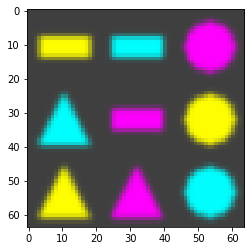

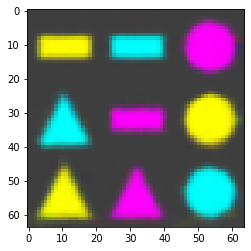

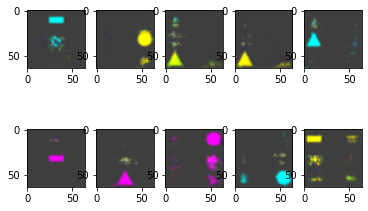

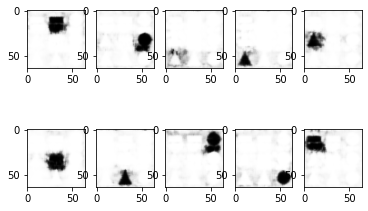

In [54]:
%matplotlib inline
from data import get_loader
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2 as cv
from parameters import parameters
loader = get_loader(total_samples=2, dataset="color_shapes", deletions=0)
iter, x = list(enumerate(loader))[0]
# x = x.to(torch.device("cuda"))
# x = x[0].permute((0,2,3,1))
model.eval()
model.module.discretize = True
if model.module.discretize:
    recon_combined, recons, masks, slots, logits, discrete = model.forward(x[0], 1000)
else:
    recon_combined, recons, masks, slots = model.forward(x[0], 1000)
plt.imshow(x[0][0].permute(1,2,0).cpu().detach().numpy())
plt.figure()
#plt.imshow(x.cpu().detach().numpy()[1])
plt.imshow(recon_combined[0].permute(1,2,0).cpu().detach().numpy())
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    ax.imshow(recons[0][i].permute(1,2,0).cpu().detach().numpy())
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    ax.imshow(masks[0][i].permute(1,2,0).cpu().detach().numpy(), cmap="Greys")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

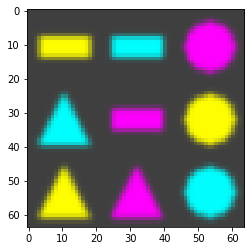

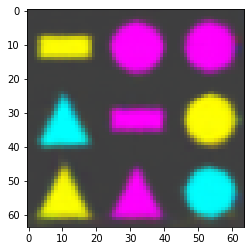

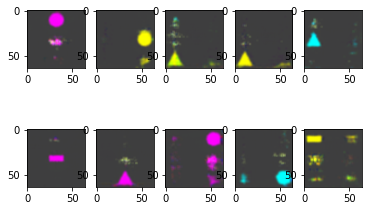

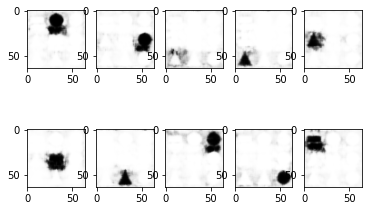

In [167]:
%matplotlib inline
from data import get_loader
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2 as cv
from parameters import parameters
# loader = get_loader(total_samples=2, dataset="color_shapes", deletions=0)
# iter, x = list(enumerate(loader))[0]
# x = x.to(torch.device("cuda"))
# x = x[0].permute((0,2,3,1))
model.eval()
model.module.discretize = True

custom_discrete = discrete.clone()

change_indices = [0,1]
slot_id = 0
for ci in change_indices:
    custom_discrete[slot_id, ci*2] = 1 - custom_discrete[slot_id, ci*2]
    custom_discrete[slot_id, ci*2 + 1] = 1 - custom_discrete[slot_id, ci*2 + 1]

if model.module.discretize:
    recon_combined, recons, masks, slots, logits, d = model.forward(x[0], 1000, discrete=custom_discrete)
else:
    recon_combined, recons, masks, slots = model.forward(x[0], 1000)
plt.imshow(x[0][0].permute(1,2,0).cpu().detach().numpy())
plt.figure()
#plt.imshow(x.cpu().detach().numpy()[1])
plt.imshow(recon_combined[0].permute(1,2,0).cpu().detach().numpy())
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    ax.imshow(recons[0][i].permute(1,2,0).cpu().detach().numpy())
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    ax.imshow(masks[0][i].permute(1,2,0).cpu().detach().numpy(), cmap="Greys")

In [140]:
%matplotlib inline
from metrics import evaluate_dsa_combined, evaluate_dsa_per_slot
model.eval()
with torch.no_grad():
    metrics = evaluate_dsa_per_slot(model, 1)

metrics

1it [00:01,  1.29s/it]


{'bit_variance': 0.0006968029,
 'discrete_usage': tensor([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0

In [11]:
du = metrics["discrete_usage"].cpu().detach().numpy()

(du > 0).sum()

92

In [12]:
19/240

0.07916666666666666